# Conservation of Cell Cylce effect
Before vs. after integration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scIB

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.3 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.20.4 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
plt.rcParams['figure.figsize'] = 8,8

In [3]:
adata_file = "/storage/groups/ml01/workspace/group.daniela/MCA_normalised/Lung.h5ad"
#adata_file = "/storage/groups/ml01/workspace/group.daniela/tm/facs/norm/Limb_Muscle_raw.h5ad"

In [4]:
adata = sc.read(adata_file, cache=True)

In [5]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 13084 genes that are detected in less than 1 cells


In [6]:
scIB.preprocessing.reduce_data(adata, hvg=True, pca=True, umap=True)
sc.tl.louvain(adata, resolution=0.5, key_added='louvain')

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

Number of highly variable genes: 3999
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:10.14)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/icb/michaela.mueller/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/icb/

    finished (0:00:07.33) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:47.25) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.98) --> found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


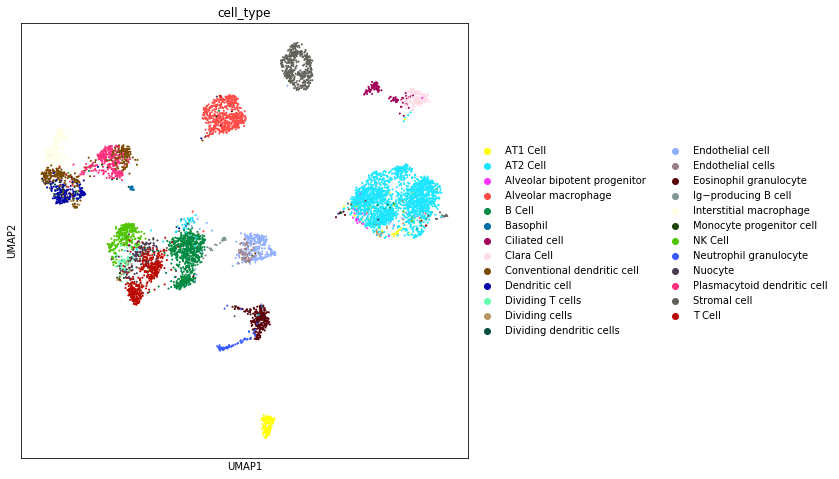

In [7]:
sc.pl.umap(adata, color=['cell_type'], palette=sc.pl.palettes.godsnot_64)

## Compute cell cycle scores

Using Tirosh et al. cell cycle marker genes

In [8]:
marker_gene_file = '../data/regev_lab_cell_cycle_genes.txt'

## Cell cycle effect

In [9]:
adata.obs.columns

Index(['batch', 'tissue', 'barcode', 'cell_type', 'marker_gene', 'n_counts',
       'log_counts', 'n_genes', 'percent_mito', 'size_factors', 'louvain'],
      dtype='object')

In [10]:
s_genes, g2m_genes = scIB.preprocessing.cc_tirosh(marker_gene_file)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:06.25) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'
    finished (0:00:05.85) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


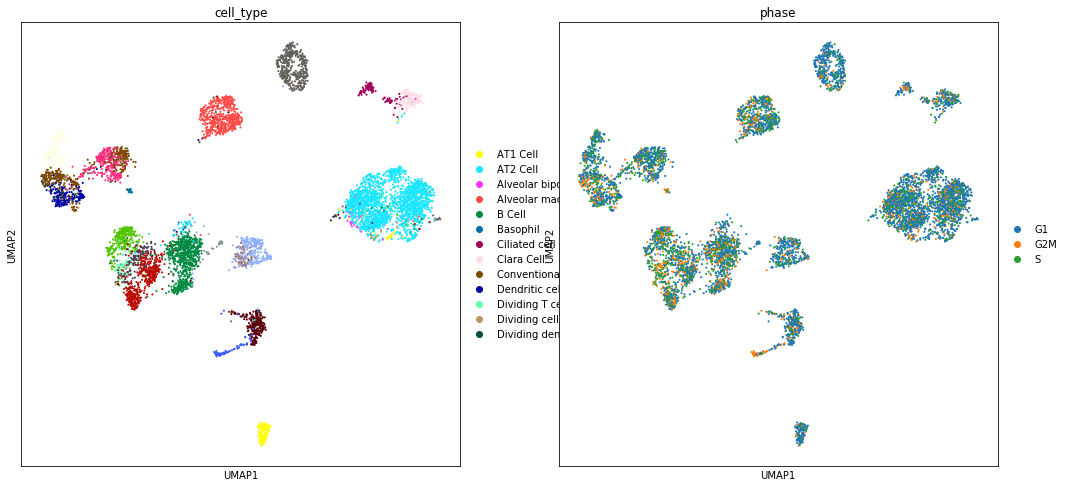

In [11]:
sc.pl.umap(adata, color=['cell_type', 'phase'])

In [12]:
effect = scIB.metrics.pcr_comparison(adata, adata.layers['counts'], adata.X, covariate="phase")
effect

subsetting to 3999 highly variable genes
covariate: phase
matrix dimensions: (6940, 3999)
computing PCA with n_comps = 3999
    finished (0:00:38.80)
importing data to R
PC regression
matrix dimensions: (6940, 3999)
computing PCA with n_comps = 3999
    finished (0:00:32.06)
importing data to R
PC regression


-0.18918769551616266

In [13]:
scIB.metrics.measureTM(scIB.metrics.pcr_comparison,
                       adata, adata.layers['counts'], adata.X, covariate="phase")

subsetting to 3999 highly variable genes
covariate: phase
matrix dimensions: (6940, 3999)
computing PCA with n_comps = 3999
    finished (0:00:36.03)
importing data to R
PC regression
matrix dimensions: (6940, 3999)
computing PCA with n_comps = 3999
    finished (0:00:33.42)
importing data to R
PC regression
memory usage:501.0 MB
runtime: 243.0 s


(501.41015625, 243.4796300000003, (-0.18918769551616266,))

In [15]:
scIB.metrics.measureTM(scIB.metrics.kBET_comparison,
                       adata, adata.layers['counts'], adata.X, covariate="phase")

covariate: phase
importing count matrix
kBET estimation
importing count matrix
kBET estimation
memory usage:5238.0 MB
runtime: 2366.0 s


(5237.81640625, 2366.3825739999993, (-1.3435899571256904e-05,))

In [16]:
adata_sub = sc.pp.subsample(adata, fraction=0.3, random_state=0, copy=True)

In [17]:
scIB.metrics.measureTM(scIB.metrics.kBET_comparison,
                       adata_sub, adata_sub.layers['counts'], adata_sub.X, covariate="phase")

covariate: phase
importing count matrix
kBET estimation
importing count matrix
kBET estimation
memory usage:1884.0 MB
runtime: 222.0 s


(1883.65234375, 222.05999999999997, (0.0060190937645535625,))

In [19]:
matrix = adata.X
sc.pp.subsample(matrix, fraction=0.3, random_state=0)

(<2082x21665 sparse matrix of type '<class 'numpy.float64'>'
 	with 1210993 stored elements in Compressed Sparse Row format>,
 array([5468, 2527, 5623, ..., 5882, 5783, 4126]))